In [1]:
import json 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from os import listdir
from xml.etree import ElementTree
from numpy import zeros

from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

C:\Users\CAU\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\CAU\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\CAU\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\CAU\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\f

In [2]:

class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "underline")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
        # extract image id
            image_id = filename[:-4]
        # skip bad images
            if image_id in ['00090']:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        # print(info)
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = int(box[1]), int(box[3])
            col_s, col_e = int(box[0]), int(box[2])
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('underline'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [3]:
train_set = KangarooDataset()
train_set.load_dataset('./underline/train', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = KangarooDataset()
test_set.load_dataset('./underline/test', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 56
Test: 6


In [4]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(1000, 1200, 3)
(1000, 1200, 33)


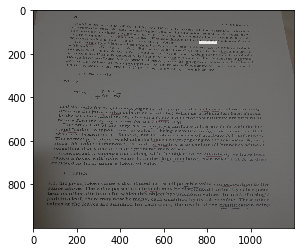

In [5]:
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 2], cmap='gray', alpha=0.5)
pyplot.show()

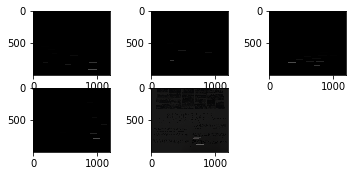

In [6]:
# plot first few images
for i in range(5):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
    pyplot.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    for j in range(mask.shape[2]):
        pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [7]:
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

In [8]:
from mrcnn.config import Config
# define a configuration for the model
class KangarooConfig(Config):
    # Give the configuration a recognizable name
    
    # --- origin
    # NAME = "kangaroo_cfg"
    NAME = "underline_cfg"
    
    # Number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 56
 
# prepare config
config = KangarooConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
from mrcnn.model import MaskRCNN
model = MaskRCNN(mode='training', model_dir='./', config=config)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
# load weights (mscoco)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [11]:
# train weights 
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./underline_cfg20191201T1657\mask_rcnn_underline_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

C:\Users\CAU\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\CAU\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\CAU\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "







Epoch 1/20
56/56 [==============================] - 186s 3s/step - loss: 3.3952 - val_loss: 2.6445
Epoch 2/20
56/56 [==============================] - 174s 3s/step - loss: 2.4151 - val_loss: 2.7780
Epoch 3/20
56/56 [==============================] - 172s 3s/step - loss: 2.1576 - val_loss: 2.2017
Epoch 4/20
56/56 [==============================] - 172s 3s/step - loss: 2.0649 - val_loss: 2.1688
Epoch 5/20
56/56 [==============================] - 174s 3s/step - loss: 1.9857 - val_loss: 2.4047
Epoch 6/20
56/56 [==============================] - 173s 3s/step - loss: 1.8926 - val_loss: 2.0350
Epoch 7/20
56/56 [==============================] - 173s 3s/step - loss: 1.9442 - val_loss: 1.9395
Epoch 8/20
56/56 [==============================] - 171s 3s/step - loss: 1.8545 - val_loss: 2.0406
Epoch 9/20
56/56 [==============================] - 173s 3s/step - loss: 1.8261 - val_loss: 1.8928
Epoch 10/20
56/56 [==============================] - 171s 3s/step - loss: 1.7731 - val_loss: 1.7574
Epoc

In [12]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
    # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        # print(mask.shape[2])
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        # print(len(yhat['rois']))
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

In [13]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [15]:
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('./mask_rcnn_underline_cfg_0020.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)


Instructions for updating:
Use `tf.cast` instead.
Train mAP: 0.874
Test mAP: 0.837


In [16]:
#Train mAP: 0.909
#Test mAP: 0.798

In [17]:
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_underline_cfg_0020.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
# plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
# plot_actual_vs_predicted(test_set, model, cfg)

In [37]:
import cv2

In [47]:
temp = cv2.imread("./underline/test/images/32.jpg")

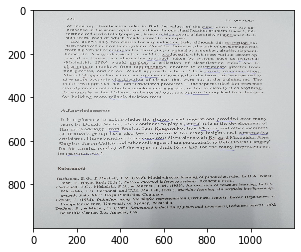

In [48]:
pyplot.imshow(temp)

In [49]:
yhat = model.detect([temp], verbose=0)[0]

In [50]:
len(yhat['rois'])

31

TypeError: Invalid shape (4,) for image data

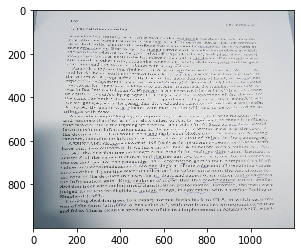

In [41]:
# plot first few images
pyplot.imshow(temp)
# plot all masks
for j in range(len(yhat['rois'])):
    pyplot.imshow(list(yhat['rois'][j]), cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [18]:
scaled_image = mold_image(temp, cfg)
sample = expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)[0]

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/convolution}}]]
	 [[mrcnn_bbox/Reshape/_4315]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
yhat

In [26]:
yhat['rois']

array([[ 433,  833,  441,  917],
       [ 453,  402,  463,  515],
       [ 764,  540,  774,  650],
       [ 788,  397,  798,  509],
       [ 697,  589,  706,  729],
       [ 242,  564,  250,  678],
       [ 760,  980,  770, 1093],
       [ 492,  379,  501,  468],
       [ 831,  693,  842,  810],
       [ 699,  405,  708,  516],
       [ 454,  644,  463,  727],
       [ 395,  736,  402,  853],
       [ 510,  745,  517,  853],
       [ 717,  752,  726,  844],
       [ 616,  325,  626,  442],
       [ 186,  529,  193,  629],
       [ 492,  752,  499,  862],
       [ 613,  709,  620,  813],
       [ 785,  810,  795,  926],
       [ 593,  799,  600,  905],
       [ 135,  661,  142,  752],
       [ 527,  920,  535, 1019],
       [ 243,  832,  252,  905],
       [ 832,  491,  842,  579],
       [ 470,  147,  479,  233],
       [ 336,  559,  343,  676],
       [ 432,  424,  440,  509],
       [ 331,  293,  340,  395],
       [ 634,  597,  643,  675],
       [ 374,  466,  381,  570],
       [ 5

In [32]:
yhat['rois'][0][1]

833

TypeError: Invalid shape (4,) for image data

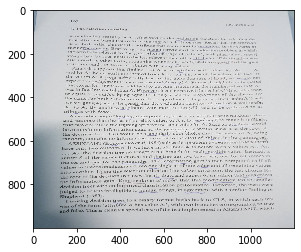

In [33]:
# plot first few images
pyplot.imshow(temp)
# plot all masks
for j in range(len(yhat['rois'])):
    pyplot.imshow(list(yhat['rois'][j]), cmap='gray', alpha=0.3)
# show the figure
pyplot.show()